<a href="https://colab.research.google.com/github/SaraKarim23/RHESSI_Mission_Data_to_Identify_Solar_Flare_Peak_Times/blob/main/RHESSI_Mission_Data_to_Identify_Solar_Flare_Peak_Times.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

data_path = '/content/drive/MyDrive/MSc/Solar /hessi.solar.flare.2002to2016.csv'
data = pd.read_csv(data_path)

data.head()

,flare,start.date,start.time,peak,end,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,flag.3,flag.4,flag.5
0,2021213,2002-02-12,21:29:56,21:33:38,21:41:48,712,136,167304,12-25,592,-358,692,0,A1,P1,NaN,NaN,NaN
1,2021228,2002-02-12,21:44:08,21:45:06,21:48:56,288,7,9504,6-12,604,-341,694,9811,A1,P1,PE,Q1,NaN
2,2021332,2002-02-13,00:53:24,00:54:54,00:57:00,216,15,11448,6-12,-310,375,487,9825,A1,P1,NaN,NaN,NaN
3,2021308,2002-02-13,04:22:52,04:23:50,04:26:56,244,20,17400,12-25,-277,378,469,9822,A1,P1,NaN,NaN,NaN
4,2021310,2002-02-13,07:03:52,07:05:14,07:07:48,236,336,313392,25-50,-272,390,476,9825,A1,GS,P1,PE,Q2


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers

data = pd.read_csv("/content/drive/MyDrive/MSc/Solar /hessi.solar.flare.2002to2016.csv", parse_dates=["start.date"])

# Converting 'start.date', 'start.time', 'end', and 'peak' to datetime
data['start_datetime'] = pd.to_datetime(data['start.date'].astype(str) + ' ' + data['start.time'])
data['end_datetime'] = pd.to_datetime(data['end'])
data['peak_datetime'] = pd.to_datetime(data['peak'])

# Scaling relevant features
features_to_scale = ['duration.s', 'total.counts', 'x.pos.asec', 'y.pos.asec']
scaler = MinMaxScaler()
data[features_to_scale] = scaler.fit_transform(data[features_to_scale])

# Extracting time features
def extract_time_features(dt):
    return dt.hour, dt.minute, dt.second

data['start_hour'], data['start_minute'], data['start_second'] = zip(*data['start_datetime'].apply(extract_time_features))
data['end_hour'], data['end_minute'], data['end_second'] = zip(*data['end_datetime'].apply(extract_time_features))
data['peak_hour'], data['peak_minute'], data['peak_second'] = zip(*data['peak_datetime'].apply(extract_time_features))

X_columns = ['duration.s','total.counts', 'x.pos.asec', 'y.pos.asec', 'start_hour', 'start_minute', 'start_second', 'end_hour', 'end_minute', 'end_second']
y_columns = ['peak_hour', 'peak_minute', 'peak_second']

X = data[X_columns].values.reshape(-1, 1, len(X_columns))
y = data[y_columns].values

def build_lstm_model(input_shape):
    model = keras.Sequential([
        keras.Input(shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.Dropout(0.2),
        layers.LSTM(32),
        layers.Dense(3)  # Predicting hour, minute, second
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

input_shape = (X.shape[1], X.shape[2])
model = build_lstm_model(input_shape)

history = model.fit(X, y, epochs=20, batch_size=64, validation_split=0.2)

<ipython-input-3-48f4ad2ba94e>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['end_datetime'] = pd.to_datetime(data['end'])
<ipython-input-3-48f4ad2ba94e>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['peak_datetime'] = pd.to_datetime(data['peak'])


Epoch 1/20
1425/1425 [==============================] - 14s 7ms/step - loss: 340.1898 - mae: 14.0598 - val_loss: 196.2669 - val_mae: 11.0287
Epoch 2/20
1425/1425 [==============================] - 7s 5ms/step - loss: 168.1688 - mae: 9.8215 - val_loss: 149.0128 - val_mae: 8.6637
Epoch 3/20
1425/1425 [==============================] - 9s 6ms/step - loss: 140.4011 - mae: 8.1232 - val_loss: 133.3270 - val_mae: 7.5712
Epoch 4/20
1425/1425 [==============================] - 9s 6ms/step - loss: 131.6864 - mae: 7.4707 - val_loss: 129.2983 - val_mae: 7.1100
Epoch 5/20
1425/1425 [==============================] - 11s 8ms/step - loss: 129.1551 - mae: 7.2012 - val_loss: 129.3351 - val_mae: 7.0830
Epoch 6/20
1425/1425 [==============================] - 8s 6ms/step - loss: 127.8649 - mae: 7.0609 - val_loss: 127.0816 - val_mae: 6.8962
Epoch 7/20
1425/1425 [==============================] - 7s 5ms/step - loss: 126.8520 - mae: 6.9743 - val_loss: 126.1670 - val_mae: 6.7454
Epoch 8/20
1425/1425 [========

In [4]:
def predict_peak_time(model, scaler, user_input):
    scaled_features_input = scaler.transform([[user_input[key] for key in features_to_scale]])

    # Adjusting unscaled_features_input to make it a 2D array by adding an extra dimension
    unscaled_features_input = np.array([user_input[key] for key in ['start_hour', 'start_minute', 'start_second', 'end_hour', 'end_minute', 'end_second']]).reshape(1, -1)
    X_user = np.hstack([scaled_features_input, unscaled_features_input]).reshape(1, 1, -1)

    predicted_peak_time = model.predict(X_user)

    return predicted_peak_time

from datetime import datetime

user_input = {
    'total.counts': 50000,
    'x.pos.asec': 100,
    'y.pos.asec': -200,
    'start_hour': 21,
    'start_minute': 29,
    'start_second': 56,
    'end_hour': 21,
    'end_minute': 41,
    'end_second': 48
}

arbitrary_date = '2000-01-01'
start_time_str = f"{arbitrary_date} {user_input['start_hour']}:{user_input['start_minute']}:{user_input['start_second']}"
end_time_str = f"{arbitrary_date} {user_input['end_hour']}:{user_input['end_minute']}:{user_input['end_second']}"

start_time = datetime.strptime(start_time_str, '%Y-%m-%d %H:%M:%S')
end_time = datetime.strptime(end_time_str, '%Y-%m-%d %H:%M:%S')

# Calculating duration.s as before
duration_seconds = (end_time - start_time).total_seconds()

# Adding duration.s to user_input
user_input['duration.s'] = duration_seconds

# Proceeding with the prediction using the fixed function
predicted_peak_time = predict_peak_time(model, scaler, user_input)

print(f"Predicted Peak Time - Hour: {int(predicted_peak_time[0][0])}, Minute: {int(predicted_peak_time[0][1])}, Second: {int(predicted_peak_time[0][2])}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 1s 798ms/step
Predicted Peak Time - Hour: 21, Minute: 32, Second: 29


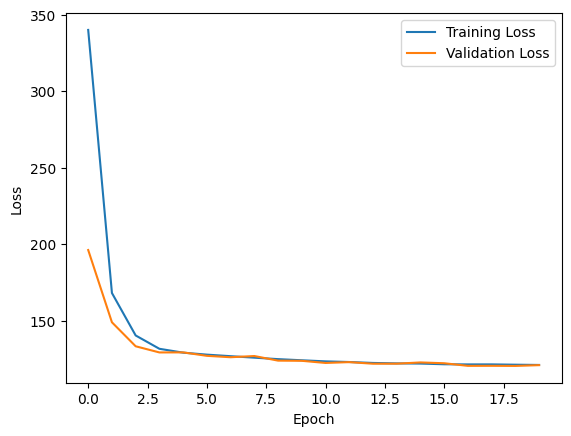

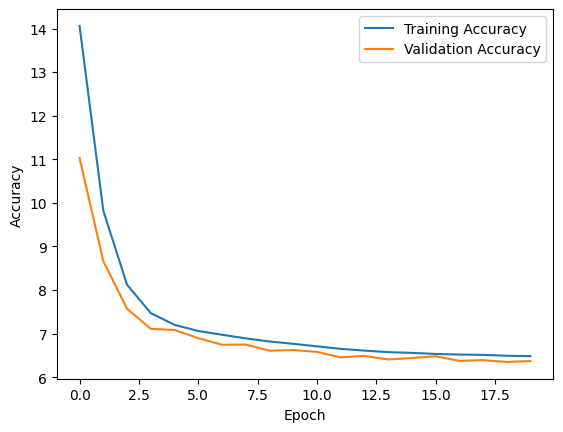

In [9]:


import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['mae'], label='Training Accuracy')
plt.plot(history.history['val_mae'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
diff = abs(y - model.predict(X))
print(diff)


3561/3561 [==============================] - 10s 3ms/step
[[ 0.51379013  0.30867767  8.07259941]
 [ 0.10442734  0.22603607 23.78399467]
 [ 0.69889492  1.05369949 24.14958763]
 ...
 [ 0.19060612  4.35487366 23.97687912]
 [ 0.70377731  1.58408546  0.17375374]
 [ 0.74057007  2.040802   15.95053673]]


In [16]:

# Calculate the difference between the predicted and actual values for each parameter
diff_duration = abs(y[:, 0] - model.predict(X)[:, 0])
diff_total_counts = abs(y[:, 1] - model.predict(X)[:, 1])
diff_x_pos = abs(y[:, 2] - model.predict(X)[:, 2])
#diff_y_pos = abs(y[:, 3] - model.predict(X)[:, 3])

# Print the differences
print("Difference in duration.s:", diff_duration)
print("Difference in total.counts:", diff_total_counts)
print("Difference in x.pos.asec:", diff_x_pos)
#print("Difference in y.pos.asec:", diff_y_pos)


3561/3561 [==============================] - 8s 2ms/step
Difference in duration.s: [0.51379013 0.10442734 0.69889492 ... 0.19060612 0.70377731 0.74057007]
Difference in total.counts: [0.30867767 0.22603607 1.05369949 ... 4.35487366 1.58408546 2.040802  ]
Difference in x.pos.asec: [ 8.07259941 23.78399467 24.14958763 ... 23.97687912  0.17375374
 15.95053673]


In [17]:


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             19200     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 31715 (123.89 KB)
Trainable params: 31715 (123.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:


# Calculate the mean squared error
mse = np.mean(np.square(y - model.predict(X)))

# Print the mean squared error
print("Mean squared error:", mse)

# Calculate the root mean squared error
rmse = np.sqrt(mse)

# Print the root mean squared error
print("Root mean squared error:", rmse)


3561/3561 [==============================] - 8s 2ms/step
Mean squared error: 120.07746072930182
Root mean squared error: 10.957986162124033


3561/3561 [==============================] - 9s 3ms/step


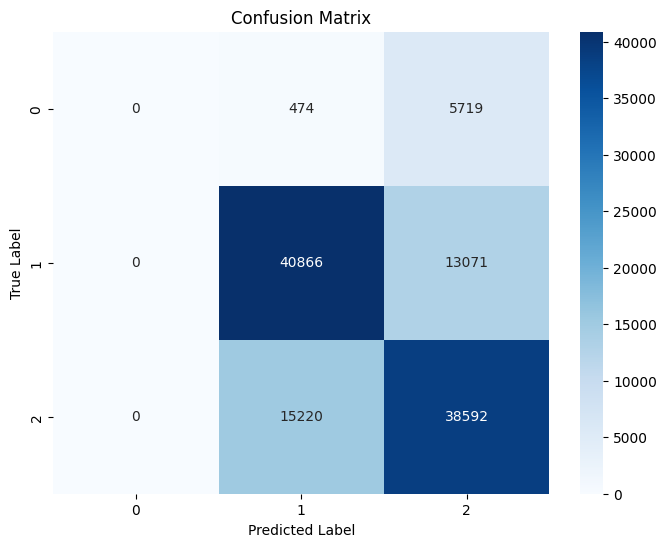

In [27]:

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Get the predicted labels
predicted_labels = np.argmax(model.predict(X), axis=1)

# Get the true labels
true_labels = np.argmax(y, axis=1)

# Generate the confusion matrix
confusion_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [38]:
from sklearn.metrics import accuracy_score

# Get the predicted labels
predicted_labels = np.argmax(model.predict(X), axis=1)

# Get the true labels
true_labels = np.argmax(y, axis=1)

# Calculate the accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the accuracy
print("Accuracy:", accuracy)


Accuracy: 0.6973547945445928
